In [48]:
import pandas as pd
import numpy as np
import json
import swifter
import nltk
import string
import re
import ast
import emoji_data_python
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import codecs
from matplotlib import pyplot as plt
import seaborn as sns

In [49]:
# load data
day_1 = pd.read_csv("/home/ruibo/Research/dartpost-research/human_eval/day_1.csv", header=0)
day_2 = pd.read_csv("/home/ruibo/Research/dartpost-research/human_eval/day_2.csv", header=0)
day_3 = pd.read_csv("/home/ruibo/Research/dartpost-research/human_eval/day_3.csv", header=0)
day_4 = pd.read_csv("/home/ruibo/Research/dartpost-research/human_eval/day_4.csv", header=0)
final_day = pd.read_csv("/home/ruibo/Research/dartpost-research/human_eval/final.csv", header=0)

In [11]:
day_1.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,2.,3,Q20,Q21.1,Q22,Q23.1,Q24,Q25,Q26,Q27
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,Post/Account #2,Post/Account #3,How strongly would you favor or oppose an incr...,How strongly do you agree or disagree with the...,How strongly do you agree or disagree with the...,How strongly would you approve or disapprove o...,How strongly would you approve or disapprove o...,When thinking about policies that affect the e...,"In the United States, the Federal Communicatio...",Do you think the federal government has done t...
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""QID24_TEXT""}","{""ImportId"":""QID25_TEXT""}","{""ImportId"":""QID26""}","{""ImportId"":""QID27""}","{""ImportId"":""QID28""}","{""ImportId"":""QID29""}","{""ImportId"":""QID30""}","{""ImportId"":""QID31""}","{""ImportId"":""QID32""}","{""ImportId"":""QID39""}"
2,2020-09-02 14:43:08,2020-09-02 14:43:45,1,NaN,100,37,1,2020-09-02 14:43:46,R_yr9metu0KXxm8jT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-02 14:46:07,2020-09-02 14:46:41,1,NaN,100,34,1,2020-09-02 14:46:42,R_3m2nkRxllwWNwMi,NaN,...,wertwre,wertwer,1,4,3,2,3,2,4,3
4,2020-09-02 14:48:43,2020-09-02 14:49:10,1,NaN,100,27,1,2020-09-02 14:49:11,R_3stxRoCTC5ncNPF,NaN,...,wetret,wertwert,2,1,1,2,3,1,3,2


In [12]:
# check the column titles
day_1.iloc[0]

StartDate                                                       Start Date
EndDate                                                           End Date
Status                                                       Response Type
IPAddress                                                       IP Address
Progress                                                          Progress
Duration (in seconds)                                Duration (in seconds)
Finished                                                          Finished
RecordedDate                                                 Recorded Date
ResponseId                                                     Response ID
RecipientLastName                                      Recipient Last Name
RecipientFirstName                                    Recipient First Name
RecipientEmail                                             Recipient Email
ExternalReference                                  External Data Reference
LocationLatitude         

In [13]:
final_day.iloc[0]

StartDate                                                       Start Date
EndDate                                                           End Date
Status                                                       Response Type
IPAddress                                                       IP Address
Progress                                                          Progress
Duration (in seconds)                                Duration (in seconds)
Finished                                                          Finished
RecordedDate                                                 Recorded Date
ResponseId                                                     Response ID
RecipientLastName                                      Recipient Last Name
RecipientFirstName                                    Recipient First Name
RecipientEmail                                             Recipient Email
ExternalReference                                  External Data Reference
LocationLatitude         

In [15]:
def return_col_score(df, col):
    """
    return the list of int given the selection col
    """
    score_series = df[df[col].notna()][col][2:]
    score_series = score_series[score_series.str.isnumeric()].tolist()
    score_series = [int(score) for score in score_series]
    return score_series

In [19]:
def return_scores(df, rtn_avg, is_final):
    """
    return the numeric selection of all cols
    """
    df = df[df['ResponseId'].notna()]
    if is_final:
        column_names = ['Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25.1', 'Q26.1', 'Q27']
    else:
        column_names = ['Q20', 'Q21.1', 'Q22', 'Q23.1', 'Q24', 'Q25', 'Q26', 'Q27']
    if rtn_avg:
        scores = [np.mean(return_col_score(df, col), dtype=np.float16) for col in column_names]
    else:
        scores = [return_col_score(df, col) for col in column_names]  # list of list, 8 * num of answers
    return scores

In [64]:
# everyday mean
all_score_day_1 = return_average_score(day_1, True, False)
all_score_day_2 = return_average_score(day_2, True, False)
all_score_day_3 = return_average_score(day_3, True, False)
all_score_day_4 = return_average_score(day_4, True, False)

# final day
all_score_final_day = return_average_score(final_day, True, True)

In [78]:
def return_everyday_df(data_list, day_name):
    df = pd.DataFrame(data_list)
    df = df.transpose()
    df.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    df['day'] = day_name
    return df

In [79]:
day_1_df = return_everyday_df(all_score_day_1, '1').head()
day_2_df = return_everyday_df(all_score_day_2, '2').head()
day_3_df = return_everyday_df(all_score_day_3, '3').head()
day_4_df = return_everyday_df(all_score_day_4, '4').head()
final_day_df = return_everyday_df(all_score_final_day, '5').head()

In [80]:
# construct a dataframe
dfs = [day_1_df, day_2_df, day_3_df, day_4_df, final_day_df]
all_days = pd.concat(dfs)
all_days.head()


,a,b,c,d,e,f,g,h,day
0,2.378906,2.000000,2.146484,1.767578,1.922852,1.344727,2.671875,2.507812,1
0,2.462891,2.210938,2.326172,1.832031,1.947266,1.294922,2.832031,2.515625,2
0,2.378906,2.117188,2.203125,1.815430,1.960938,1.303711,2.796875,2.503906,3
0,2.384766,2.115234,2.187500,1.843750,1.916992,1.323242,2.812500,2.541016,4
0,2.429688,2.162109,2.226562,1.795898,1.957031,1.354492,2.859375,2.558594,5


In [81]:
all_days = pd.melt(all_days, "day", var_name="all_topics")

In [82]:
all_days.head()

,day,all_topics,value
0,1,a,2.378906
1,2,a,2.462891
2,3,a,2.378906
3,4,a,2.384766
4,5,a,2.429688


In [72]:
def return_n(text):
    if text == 'day_1':
        return 1
    elif text == 'day_2':

40

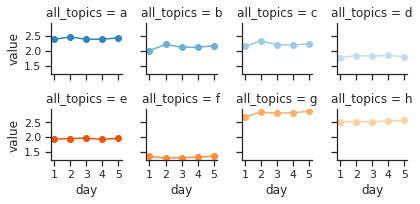

In [84]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(all_days, col="all_topics", hue="all_topics", palette="tab20c",
                     col_wrap=4, height=1.5)

grid.map(plt.plot, "day", "value", marker="o")